<a href="https://colab.research.google.com/github/jnkx9c/DL_Project/blob/master/MoodDetection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jeff Kilgore
##Deep Learning Project:  Mood Detection

This goal of this project is to create a DL model which can detect my 5 moods:  cry, neutral, happy, sad, laugh.

1000 images were captured of my face, around 200 per mood.  The images were sliced out of video files, and cropped down to just my face using software.

The images were randomly divided into 3 folders:  training (600), validation (200), and testing(200).  The images were then placed into sub-folders based on their class.  The folders were then zipped up and checked into github.



##Download and upzip the input images.

In [1]:
import requests, zipfile, io, os
import os

print('Downloading and unzipping test file.')
r = requests.get('https://github.com/jnkx9c/DL_Project/raw/master/moods_images1_win.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()




##Print the number of images in each stage/mood folder
###Data has already been randomized and sorted into 3 folders, 
*  train
*  validate
*  test

Inside each folder, the data has been further subdivided into classes (moods)
*  cry
*  neutral
*  sad
*  laugh
*  smile



In [2]:



base_dir = 'moods_images1_win/moods_win'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for mood in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+mood+': '+str(len(os.listdir(base_dir+'/'+s+'/'+mood))))
  print('-----')

  
    

moods_images1_win/moods_win/validate/smile: 35
moods_images1_win/moods_win/validate/sad: 39
moods_images1_win/moods_win/validate/neutral: 40
moods_images1_win/moods_win/validate/cry: 40
moods_images1_win/moods_win/validate/laugh: 46
-----
moods_images1_win/moods_win/test/smile: 49
moods_images1_win/moods_win/test/sad: 31
moods_images1_win/moods_win/test/neutral: 39
moods_images1_win/moods_win/test/cry: 41
moods_images1_win/moods_win/test/laugh: 40
-----
moods_images1_win/moods_win/train/smile: 116
moods_images1_win/moods_win/train/sad: 130
moods_images1_win/moods_win/train/neutral: 121
moods_images1_win/moods_win/train/cry: 119
moods_images1_win/moods_win/train/laugh: 114
-----


##Create the data generators
3 ImageDataGenerators are used to feed the images to the model.

Because the training dataset is small, Data Augmentation is used on the training set, to rotate the image +/- 10 degrees,  and randomize the brightness.

In [3]:
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    brightness_range=[0.8,1.2],
    fill_mode='nearest' 
    )

validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical',
        color_mode='grayscale')
class_dictionary = train_generator.class_indices
print(class_dictionary)

validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical',
        color_mode='grayscale')






Using TensorFlow backend.


Found 600 images belonging to 5 classes.
{'cry': 0, 'laugh': 1, 'neutral': 2, 'sad': 3, 'smile': 4}
Found 200 images belonging to 5 classes.


#Visualize some of the data from the Training Data Generator
Note you can see the brightness differences in the images.  This is from the data-augentation.

Found 600 images belonging to 5 classes.


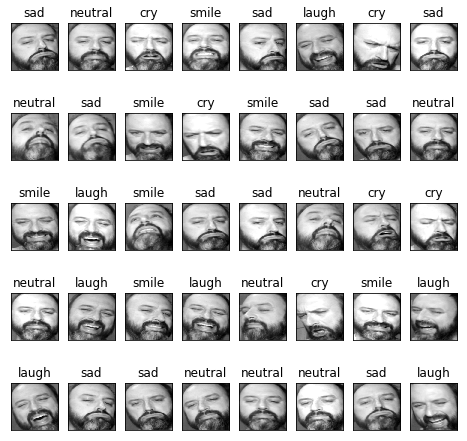

In [ ]:

i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        color_mode='grayscale'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

In [ ]:
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def train_model(model,epochs=25):
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=100, callbacks=[])
  plot_history(history)
  

#Model Architecture
I found that with shallower models (less layers), the training and validation accuracy rose quickly over just a few epochs. While the validation accuracy never really started to decline, I assumed the model was quickly overfitting.  To avoid this, I started adding more Conv2D layers with an increasing number of filters.  To reduce the number of parameters, I added MaxPooling between the Conv layers.  Finally, to make the model more generalized, a Dropout layer was added before the last Conv layer.  

Adding the additional layers slowed the learning rate to a smoother curve.


##Single Conv Layer Model Training
This model did very poorly, 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
flatten_13 (Flatten)         (None, 4129024)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 20645125  
Total params: 20,645,765
Trainable params: 20,645,765
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
100/100 [==============================] - 14s 142ms/step - loss: 2.0360 - acc: 0.2150 - val_loss: 1.6060 - val_acc: 0.1955
Epoch 2/25
100/100 [==============================] - 13s 133ms/step - loss: 1.6048 - acc: 0.2520 - val_loss: 1.6433 - val_acc: 0.1945
Epoch 3/25
100/100 [==============================] - 15s 146ms/step - loss: 1.4589 - acc: 0.3850 - val_loss: 1.1559 - val_a

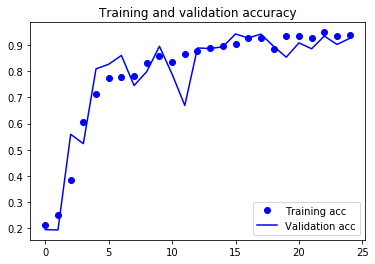

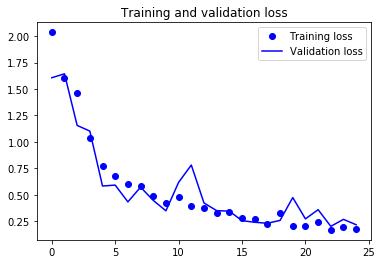

In [ ]:


model = models.Sequential()
model.add( layers.Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()
model.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ],)

train_model(model)


## 2 Conv Layer Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 252, 252, 128)     73856     
_________________________________________________________________
flatten_15 (Flatten)         (None, 8128512)           0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 40642565  
Total params: 40,717,061
Trainable params: 40,717,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
100/100 [==============================] - 27s 273ms/step - loss: 1.7851 - acc: 0.2000 - val_loss: 1.6094 - val_acc: 0.1950
Epoch 2/25
100/100 [==============================] - 26s 260ms/step - loss: 1.6088 - acc: 0.2160 - val_loss: 1.6077 - val_acc:

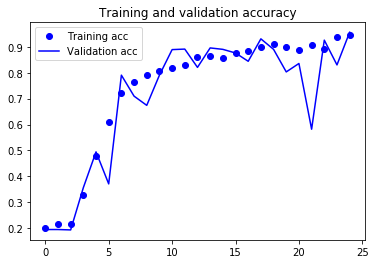

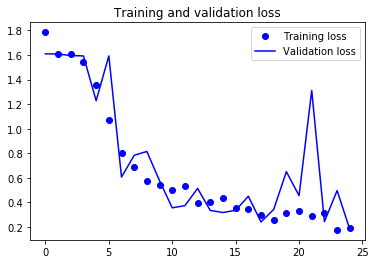

In [ ]:
model = models.Sequential()
model.add( layers.Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
model.add( layers.Conv2D( 128, ( 3, 3 ), activation = 'relu' ) )


model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()
model.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ],)

train_model(model)

##2 Conv Layer with MaxPooling

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 125, 125, 128)     73856     
_________________________________________________________________
flatten_18 (Flatten)         (None, 2000000)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 10000005  
Total params: 10,074,501
Trainable params: 10,074,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
100/100 [==============================] - 16s 158ms/step - loss: 1.6347 - acc: 0.2435 - val_loss: 1.5808 - val_acc: 0.

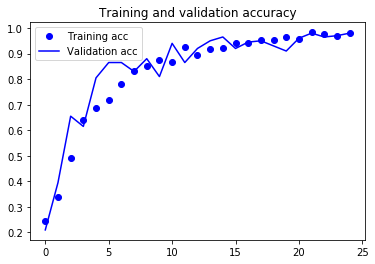

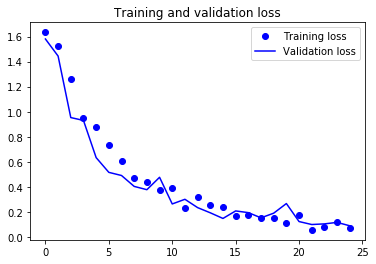

In [ ]:
model = models.Sequential()
model.add( layers.Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 128, ( 3, 3 ), activation = 'relu', ) )

model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()
model.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ],)
train_model(model)

##4 Conv Layers with MaxPooling

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 254, 254, 8)       80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 60, 60, 64)        9280      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 128)       73856     
__________

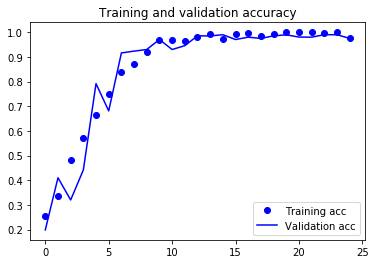

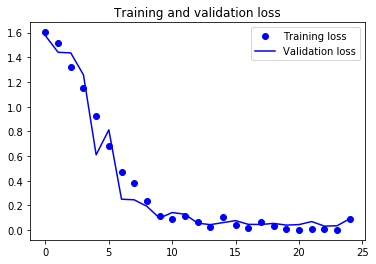

In [ ]:
model = models.Sequential()
model.add( layers.Conv2D( 8, ( 3, 3 ), activation = 'relu',input_shape=(256, 256, 1) ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 64, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 128, ( 3, 3 ), activation = 'relu' ) )

model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()
model.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ],)
train_model(model)

##5 Conv Layers with MaxPooling

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 254, 254, 4)       40        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 125, 125, 8)       296       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 60, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 64)        9280      
__________

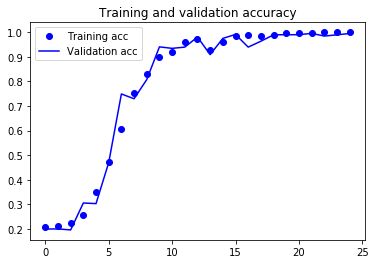

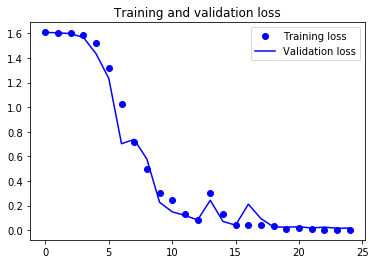

In [ ]:
model = models.Sequential()

model.add( layers.Conv2D( 4, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 8, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 64, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 128, ( 3, 3 ), activation = 'relu' ) )

model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()
model.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ],)
train_model(model)

##5 Conv Layers with MaxPooling and Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 254, 254, 4)       40        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 125, 125, 8)       296       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 60, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 64)        9280      
__________

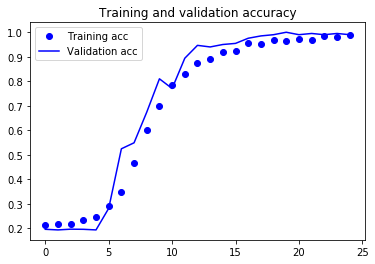

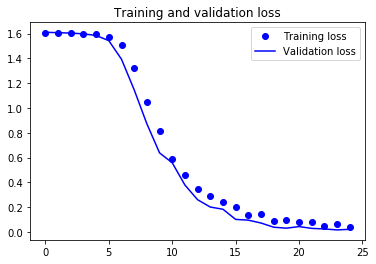

In [ ]:
model = models.Sequential()

model.add( layers.Conv2D( 4, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 8, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add( layers.Conv2D( 64, ( 3, 3 ), activation = 'relu' ) )
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=.5, noise_shape=None, seed=None));
model.add( layers.Conv2D( 128, ( 3, 3 ), activation = 'relu' ) )

model.add( layers.Flatten() )
model.add( layers.Dense( 5, activation = 'softmax' ) )
model.summary()
model.compile( optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ],)
train_model(model)

#Visualize the training and accuracy curves
Notice that the training starts slow and accuracy hangs around the baseline accuracy (20%) until 5 epochs, then it takes off.  Accuracy steadily increases until the 14th epoch, then gradually starts to flatten out again. 

During the majority of the training, the validation accuracy is higher than the training accuracy.  This is due to the DropOut layer added to the model.  However, for the last few epochs, the validation and training accuracy slowly starts to converge.  Finally, at the last epoch (25), the validation accuracy drops slighly and equals the training accuracy.  This seems to be the best place to stop the training to avoid overfitting.

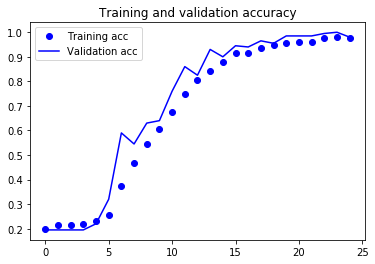

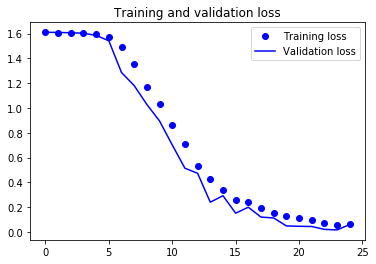

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Create the DataGenerator for the test data.

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical',
        color_mode='grayscale')

Found 200 images belonging to 5 classes.


#Evaluate the test data

In [ ]:
testing_loss, testing_acc =model.evaluate_generator(test_generator,                                                    
                                                    max_queue_size=10,
                                                    steps=20,
                                                    workers=1, 
                                                    use_multiprocessing=False, 
                                                    verbose=0)

print( 'testing_acc:', testing_acc )

testing_acc: 0.964999994635582


#Save the model to a file

In [ ]:
model.save('moods_win_dataaug1.h5')